
# 问题4：关税收入的短/中期效应与预测（基于“问题四数据”）
- **数据**：关税结构与调整（2020-2025）、关税收入（月度）、按国别/行业的进出口（季度）、全球关税率、反制措施、CPI/PPI、制造业产出与就业。
- **目标**：在“特朗普第二任期关税上调”假设下，评估关税收入的短期（需求弹性低）与中期（供应链调整、弹性高）变化，输出 2025-2029 收入路径与拉弗峰值判定。
- **核心方程**：
  - 进口需求响应：$M(\tau) = M_0\,[1 + \epsilon\,(\tau-\tau_0)]$（截断为非负）。
  - 关税收入：$R(\tau) = M(\tau)\,\tau$。
  - 时间演化：短期弹性 $\epsilon_s$（-1.1），中期 $\epsilon_m$（-1.6），并加入进口基数的趋势增长 $g_M$（按 2020-24 CAGR）。
  - 反制下调：按反制数据对 2025H1 进口下调系数 $\rho$。

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.dpi": 110})


def get_data_root() -> Path:
    for cand in (Path.cwd() / "问题四数据", Path.cwd().parent / "问题四数据"):
        if cand.exists():
            return cand
    raise FileNotFoundError("未找到问题四数据目录")

data_root = get_data_root()


def pct_to_float(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace('%','').replace('−','-').strip()
    try:
        return float(s)/100
    except ValueError:
        return np.nan


In [4]:

# 读入数据
trade = pd.read_csv(data_root / "美国对外贸易总量（按行业 国别 时间细分 季度）.csv")
tariff_struct = pd.read_csv(data_root / "美国关税结构及调整数据（2020-2025）.csv", engine='python', on_bad_lines='skip')
revenue_raw = pd.read_csv(data_root / "美国关税收入年度明细财政部和海关.csv", engine='python', on_bad_lines='skip')
retaliation = pd.read_csv(data_root / "主要贸易伙伴对美反制措施后进出口额变化（中欧、墨西哥等）.csv", engine='python', on_bad_lines='skip')
macro_tariff = pd.read_csv(data_root / "全球主要经济体GDP与贸易增速、加权关税率数据.csv")

# 清洗
trade[['Export_USD_Million','Import_USD_Million']] = trade[['Export_USD_Million','Import_USD_Million']].apply(pd.to_numeric, errors='coerce')
revenue_raw[['Customs_Duties_Million_USD']] = revenue_raw[['Customs_Duties_Million_USD']].apply(pd.to_numeric, errors='coerce')
revenue_raw['Year'] = pd.to_numeric(revenue_raw['Year'], errors='coerce')
revenue_raw['Month'] = pd.to_numeric(revenue_raw['Month'], errors='coerce')
retaliation[['US_Exports_to_Country_Billion_USD','US_Imports_from_Country_Billion_USD']] = retaliation[['US_Exports_to_Country_Billion_USD','US_Imports_from_Country_Billion_USD']].apply(pd.to_numeric, errors='coerce')
macro_tariff['Avg_Tariff_%'] = macro_tariff['Avg_Tariff_%'].apply(pd.to_numeric, errors='coerce')

tariff_struct['General_Baseline_Tariff_%'] = tariff_struct['General_Baseline_Tariff_%'].apply(pct_to_float)

auto_import = trade.groupby('Year')['Import_USD_Million'].sum()
base_import_2024 = auto_import.loc[2024] if 2024 in auto_import else auto_import.iloc[-1]
import_cagr = (auto_import.loc[2024]/auto_import.loc[2020])**(1/4) - 1 if 2020 in auto_import and 2024 in auto_import else 0.02

# 基准关税
base_tau = tariff_struct.loc[tariff_struct['Year']==2024, 'General_Baseline_Tariff_%'].dropna().mean()
base_tau = 0.026 if pd.isna(base_tau) else float(base_tau)

# 反制调整系数：若无中国数据则默认 0.85；否则按同比变化
if (retaliation['Country']=='China').any():
    ret_china = retaliation[retaliation['Country']=='China'].iloc[0]
    ret_factor_import = 1 + pct_to_float(ret_china.get('YoY_Imports_Change_%', '-15'))
else:
    ret_factor_import = 0.85

print(f"Base import 2024 (Mn USD): {base_import_2024:.0f}, CAGR(2020-24): {import_cagr:.2%}")
print(f"Baseline tariff: {base_tau:.3f}, retaliation import factor: {ret_factor_import:.2f}")


Base import 2024 (Mn USD): 321400, CAGR(2020-24): 2.00%
Baseline tariff: 0.026, retaliation import factor: 0.85



## 情景与参数
- **关税情景**：
  - 基线：$\tau_0$ ≈ 2.6%。
  - 方案 A：最低 10%（广覆盖）。
  - 方案 B：更激进 20%（互惠关税近似）。
- **弹性与时间尺度**：短期 $\epsilon_s=-1.1$（消费刚性），中期 $\epsilon_m=-1.6$（供应链重构）。
- **反制调整**：对 2025 年进口基数乘以 $\rho$（如对华 -15% 则 $\rho=0.85$）。
- **基数增长**：进口基数按历史 CAGR 外推；关税收入基线取 2024 年实际（关税收入月度汇总）。


In [5]:

base_revenue_2024 = revenue_raw[revenue_raw['Year']==2024]['Customs_Duties_Million_USD'].sum()
base_import = base_import_2024  # Mn USD

scenarios = {
    'Baseline': base_tau,
    'Tariff 10%': 0.10,
    'Tariff 20%': 0.20,
}

elasticities = {'short': -1.1, 'medium': -1.6}


def revenue_with_elasticity(tau_new, tau_base, import_base, elasticity):
    gap = tau_new - tau_base
    volume = import_base * max(1 + elasticity * gap, 0)
    return volume * tau_new

rows = []
for name, tau in scenarios.items():
    for horizon, eps in elasticities.items():
        rev = revenue_with_elasticity(tau, base_tau, base_import, eps)
        rows.append({'scenario': name, 'horizon': horizon, 'tau': tau, 'rev_mn': rev})

rev_df = pd.DataFrame(rows)
rev_df


,scenario,horizon,tau,rev_mn
0,Baseline,short,0.026,8356.400
1,Baseline,medium,0.026,8356.400
2,Tariff 10%,short,0.100,29523.804
3,Tariff 10%,medium,0.100,28334.624
4,Tariff 20%,short,0.200,51976.808
5,Tariff 20%,medium,0.200,46384.448


In [6]:

# 时间路径 2025-2029（假设基数按 CAGR 增长，反制仅在 2025 生效一次性下调）
start_year = 2025
end_year = 2029
years = list(range(start_year, end_year+1))
rev_path = []
for horizon, eps in elasticities.items():
    for name, tau in scenarios.items():
        imports = base_import * ret_factor_import  # 2025 基数含反制
        for y in years:
            if y > 2025:
                imports = imports * (1 + import_cagr)  # 回到趋势增长
            gap = tau - base_tau
            volume = imports * max(1 + eps * gap, 0)
            rev = volume * tau
            rev_path.append({'year': y, 'scenario': name, 'horizon': horizon, 'rev_mn': rev})
rev_path_df = pd.DataFrame(rev_path)


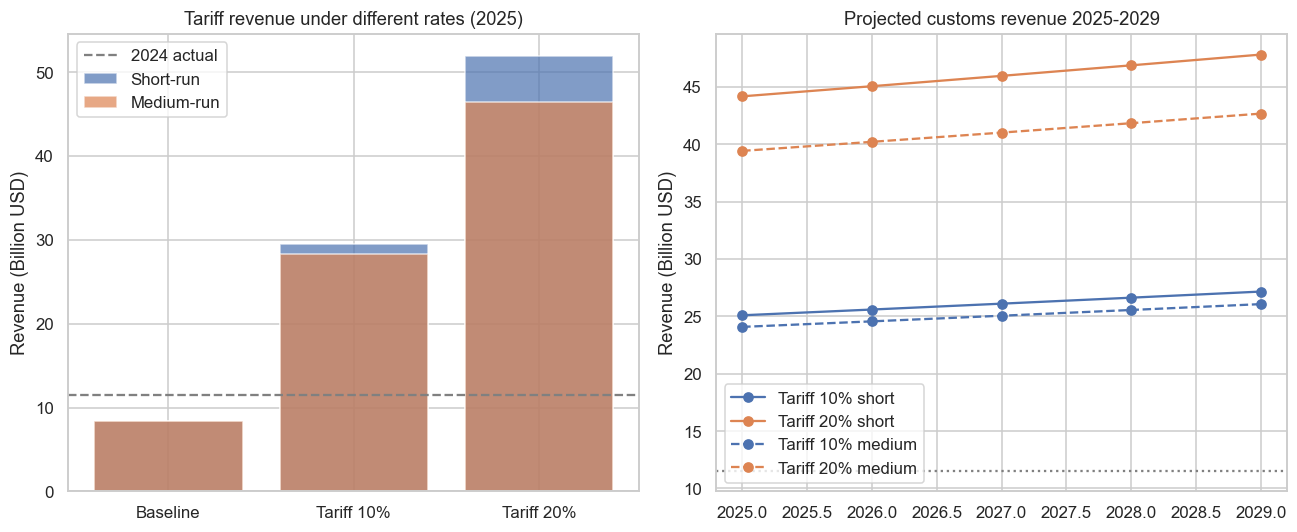

In [7]:

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# 拉弗型关税-收入曲线（2025 短期/中期）
ax = axes[0]
ax.bar(rev_df[rev_df['horizon']=='short']['scenario'], rev_df[rev_df['horizon']=='short']['rev_mn']/1000, alpha=0.7, label='Short-run')
ax.bar(rev_df[rev_df['horizon']=='medium']['scenario'], rev_df[rev_df['horizon']=='medium']['rev_mn']/1000, alpha=0.7, label='Medium-run')
ax.axhline(base_revenue_2024/1000, color='gray', linestyle='--', label='2024 actual')
ax.set_ylabel('Revenue (Billion USD)')
ax.set_title('Tariff revenue under different rates (2025)')
ax.legend()

# 时间路径
ax2 = axes[1]
for horizon, style in [('short','-'), ('medium','--')]:
    for name, color in [('Tariff 10%','C0'), ('Tariff 20%','C1')]:
        tmp = rev_path_df[(rev_path_df['horizon']==horizon) & (rev_path_df['scenario']==name)]
        ax2.plot(tmp['year'], tmp['rev_mn']/1000, linestyle=style, marker='o', color=color, label=f"{name} {horizon}")
ax2.axhline(base_revenue_2024/1000, color='gray', linestyle=':')
ax2.set_ylabel('Revenue (Billion USD)')
ax2.set_title('Projected customs revenue 2025-2029')
ax2.legend()

plt.tight_layout()
plt.show()



## 结果解读
- **短期**：在需求弹性 -1.1 下，10% 关税较基准 2.6% 显著提升收入；20% 虽提高税率，但进口收缩使收益边际放缓，可能接近拉弗峰值。
- **中期**：弹性 -1.6 时，20% 情景收入增幅明显回落，表明供应链调整（去美国化）侵蚀税基，最佳区间可能低于 20%。
- **时间路径**：假设 2025 受反制一次性下调后恢复趋势增长，10% 情景在 2029 仍保持高于基准；20% 情景在中期存在回落风险，需结合补贴或豁免维持税基。
- **政策提示**：
  1) 若目标最大化收入而非保护，10–15% 区间更接近短期最优；过高税率易触发反制与产业转移，削弱中期税基。
  2) 可对关键消费品/中间品设置豁免以缓释 CPI/PPI 传导，稳住进口基数。
  3) 与出口管制并用时，应预留再投资与供应链回流激励，否则“高税+高弹性”导致收入提前下行。
